In [1]:
from __future__ import print_function
from __future__ import division
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

def get_distance(vector_a, vector_b):
    """
    计算两个向量之间的余弦相似度
    :param vector_a: 向量 a 
    :param vector_b: 向量 b
    :return: sim
    """
    #print(vector_a.shape,vector_b.shape)
    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
#     sim = 0.5 + 0.5 * cos
    return cos

def get_best(x,pattern_vector_dict,hold=0.9):
#     res = []
    score = 0
    best_path = ""
    for k in pattern_vector_dict:
        tmp_score = get_distance(x,pattern_vector_dict[k])
        if tmp_score > score:
            score = tmp_score
            best_path = k
    if score > hold:
        print(best_path,score)
    return best_path,score
    
    
transfrom_tensor =  transforms.Compose([  
             transforms.Resize(250),                    
         transforms.CenterCrop(224),  
         transforms.ToTensor(),                    
         transforms.Normalize(                      
         mean=[0.485, 0.456, 0.406],               
         std=[0.229, 0.224, 0.225]                 
         )])
# ])

PyTorch Version:  1.10.1+cu113
Torchvision Version:  0.11.2+cu113


In [2]:
import os
import re
from typing import List, Optional

import click
import dnnlib
import numpy as np
import PIL.Image
import torch

import legacy


device = torch.device('cuda')
with dnnlib.util.open_url("./training-runs/00001-process_img-mirror-auto1/network-snapshot-004000.pkl") as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore



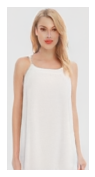

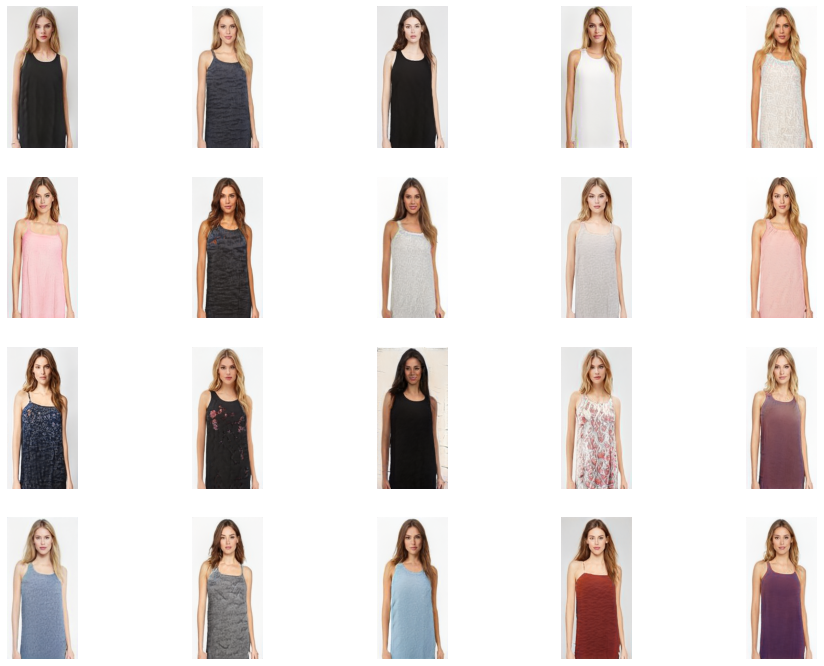

In [4]:


# 随机放向测试重建

n=1
plt.figure(figsize=(3,3))
plt.axis("off")
im_ori = Image.open("out/proj.png")
# v1 = ws_np[n]
v1 = np.load("out/projected_w.npz")['w'][0]
plt.imshow(im_ori)
mask = np.array(Image.open("test_data/2_mask.png").convert("L"))



bi = 6
ti = 14
pi = 0.8
a = 1
# plt.subplots_adjust(wspace =1, hspace =1)

with torch.no_grad():
    plt.figure(figsize=(16,12))
    for i in range(20):
    #     a = 0
        z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
        v2 = G.mapping(z,0,truncation_psi=pi)[0]
        ws = np.concatenate([v1[:bi],(v1[bi:ti] * (1-a) + a*(v2.cpu().numpy()[bi:ti])),v1[ti:]])
        ws = torch.tensor(ws.reshape(1,14,512), device=device)
        
#         if "cur_handle" in locals():
#             print("remove handle")
#             cur_handle.remove()
#         cur_handle = G.synthesis.b256.register_forward_hook(forward_hook_wrap(torch.tensor(v1.reshape(1,14,512)).cuda(),mask))

        # nws = (ws - G.mapping.w_avg) * 0.5 + G.mapping.w_avg
        img = G.synthesis(ws, noise_mode="random")
#         img = G.synthesis(v1,ws,mask, noise_mode="random")
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        img = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
    #     img.resize((300,300)).save("result/"+str(i)+".png")

        plt.subplot(4,5,1+ i)
        plt.axis("off")
        plt.imshow(img)


# 换头测试

In [233]:
import collections
def forward_hook_wrap(ws,i):
    def forward_hook(module,input,output):
        
        module._forward_hooks = collections.OrderedDict()
        #         hook_dic[module.name]
#         output[0,cur_channel] += cur_num
#         print(module,len(input))
#         print(input[0].shape,input[1].shape,input[2].shape)

        
        new_ws = ws
#         if i == 0:
#             new_ws = ws
# #             print(module,len(input),input[0],input[1],new_ws.shape)
#         else:
#             new_ws = torch.cat([ws,ws[:,1:2,:]],1)
            
#         print(input[2] == new_ws)
#         print(input[2])
        
#         print(i,new_ws.shape)
        
        output1 = module.forward(input[0],input[1],new_ws) 
        size = output1[0].shape[2]

#         print(len(output1),output1[0].shape,output1[1].shape)
#         print(size)

        mask = np.array(PIL.Image.open("test_data/2_mask.png").convert("L"))
        mask = torch.Tensor(mask).cuda().reshape(1,1,256,128) / 255
        mask = torch.nn.functional.interpolate(mask,scale_factor=size/256)
        
#         mask = mask * 0 
#         mask = np.zeros((int(size/2),size))
#         mask[:int(size/2),:] = 1
#         mask = torch.Tensor(mask).cuda()

#         print(output1[0].shape,mask.shape)

#         final_output1 = output1[0] * mask + output[0] * (1-mask)
#         final_output1 = output1[0]
        final_output1 = output1[0] * (1-mask) + output[0] * mask
#         final_output2 = output1[1] * (1-mask) + output[1] * mask
        final_output2 = output1[1]
        final_output = (final_output1,final_output2)
        
        return final_output
    return forward_hook


In [23]:
ws2 = torch.from_numpy(np.load("out/projected_w.npz")['w'][0]).cuda().reshape(1,14,512)

In [69]:
wss = []
for k in range(20):
    
    z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
    ws = G.mapping(z,0)
    a = 0.9
    s = 6
    e = 14
    ws = ws2 * (1-a) + ws * a
    ws = torch.cat([ws2[:,:s],ws[:,s:e],ws2[:,e:]],1)
    wss.append(ws)

/root/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/root/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/root/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavi

/root/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/root/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/root/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavi

/root/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/root/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/root/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavi

/root/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/root/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/root/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavi

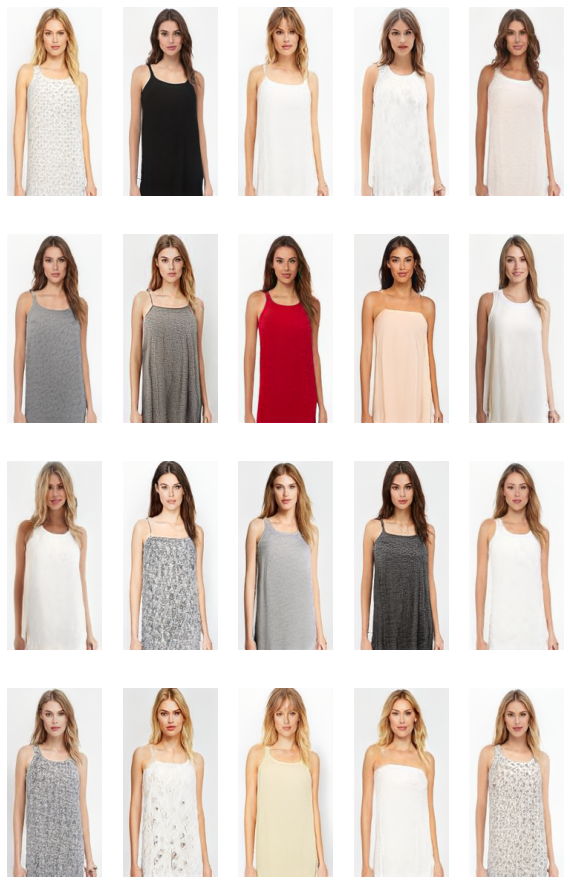

In [250]:
%matplotlib inline
import  matplotlib.pyplot as plt
from PIL import Image
import random
plt.figure(figsize=(10,16))
plt.axis("off")

img_lst = []
o_img_lst = []
for k in range(20):
    
#     z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
#     ws = G.mapping(z,0)
#     a = 0.8
#     s = 6
# #     ws = ws2 * (1-a) + ws * a
#     ws = torch.cat([ws2[:,:s],ws[:,s:]],1)
    ws = wss[k]
    
    for i,m in enumerate(G.synthesis.children()):
        if i==0:
            cur_ws = ws[:,0:2,:]
        else:
            cur_ws = ws[:,2*i-1:2*i+2,:]
#         print(cur_ws.shape)
        m.register_forward_hook(forward_hook_wrap(cur_ws,i))
    img = G.synthesis(ws2, noise_mode="random")

    o_img = G.synthesis(ws, noise_mode="random")
    o_img = (o_img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    o_img = PIL.Image.fromarray(o_img[0].cpu().numpy(), 'RGB')
    
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
    
    img_lst.append(img)
    o_img_lst.append(o_img)
    plt.subplot(4,5,k+1)
    plt.axis("off")
    plt.imshow(o_img)
    
#     plt.imshow(im_diff)
plt.savefig('result/swap_style.jpg')

In [217]:
for i,m in enumerate(G.synthesis.children()):
#     if i == 0 or i > 3:continue
    m._forward_hooks = collections.OrderedDict()

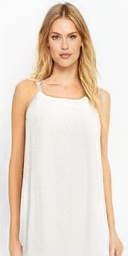

In [235]:
i = 0
img_lst[i]

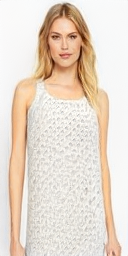

In [236]:
o_img_lst[i]

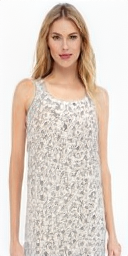

In [165]:
img = G.synthesis(ws, noise_mode="random")
#         img = G.synthesis(v1,ws,mask, noise_mode="random")
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [70]:
x = ws[:,i*2:(i+1)*2,:]

In [71]:
x.shape

torch.Size([1, 2, 512])

<Figure size 432x288 with 0 Axes>

In [214]:
for i in range(14):
    print(ws2[0,i][0])

tensor(3.0597, device='cuda:0')
tensor(0.5286, device='cuda:0')
tensor(0.8727, device='cuda:0')
tensor(3.1756, device='cuda:0')
tensor(2.8509, device='cuda:0')
tensor(-0.0922, device='cuda:0')
tensor(1.7232, device='cuda:0')
tensor(-1.1031, device='cuda:0')
tensor(0.3007, device='cuda:0')
tensor(1.7527, device='cuda:0')
tensor(0.6788, device='cuda:0')
tensor(-1.8284, device='cuda:0')
tensor(1.1235, device='cuda:0')
tensor(0.2636, device='cuda:0')


In [187]:
for i in range(6):
    print(ws2[:,i*2:(i+1)*2,:])

tensor([[[ 3.0597,  0.2979,  0.6299,  ...,  2.0820,  2.7191, -1.1959],
         [ 0.5286, -0.5163,  0.6433,  ...,  3.0043,  2.6931,  1.6253]]],
       device='cuda:0')
tensor([[[ 0.8727,  1.2724,  1.1631,  ...,  4.3814,  3.4985,  2.5238],
         [ 3.1756, -0.1575,  1.3210,  ...,  1.7038,  3.4094,  0.6104]]],
       device='cuda:0')
tensor([[[ 2.8509,  1.4965,  0.8786,  ...,  2.8803,  3.4457,  3.4592],
         [-0.0922,  2.1066,  0.0054,  ..., -0.1072,  1.9675,  1.7854]]],
       device='cuda:0')
tensor([[[ 1.7232,  1.1979,  2.6066,  ..., -1.0914,  1.5593,  1.6920],
         [-1.1031,  0.4850, -0.1038,  ...,  0.5689,  0.3856, -1.7578]]],
       device='cuda:0')
tensor([[[ 0.3007,  1.3176,  1.8285,  ...,  0.8987,  3.2109,  1.3918],
         [ 1.7527,  3.1176,  2.0844,  ..., -1.2190,  0.1585, -0.2320]]],
       device='cuda:0')
tensor([[[ 0.6788,  0.4668, -1.2449,  ...,  0.2575,  1.2224,  0.7779],
         [-1.8284,  0.0442,  1.2061,  ..., -0.1268, -1.0513,  2.2834]]],
       device='c

In [215]:
ws2

tensor([[[ 3.0597,  0.2979,  0.6299,  ...,  2.0820,  2.7191, -1.1959],
         [ 0.5286, -0.5163,  0.6433,  ...,  3.0043,  2.6931,  1.6253],
         [ 0.8727,  1.2724,  1.1631,  ...,  4.3814,  3.4985,  2.5238],
         ...,
         [-1.8284,  0.0442,  1.2061,  ..., -0.1268, -1.0513,  2.2834],
         [ 1.1235,  3.7328,  3.1169,  ...,  0.4989,  0.2483,  3.5645],
         [ 0.2636,  1.0682, -0.0504,  ..., -0.2397,  0.5813,  0.4371]]],
       device='cuda:0')

In [ ]:
[-0.4728,  1.0275,  0.3074,  ..., -0.1781,  0.7984,  0.2055],
         [-0.1776,  1.3964,  0.4985,  ..., -0.1155,  0.9283,  0.3336],
         [-0.2636,  1.1299,  0.1818,  ..., -0.1894,  0.9616,  0.0209]